# The Battle of Neighborhoods
## IBM Capstone Project

### 2. Data Acquisition and Preprocessing 

Import libraries

In [1]:
import numpy as np
import pandas as pd
!conda install -c conda-forge folium --yes
import folium
import json
from folium import plugins

print('libraries imported')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  branca             conda-forge/noarch::branca-0.4.1-py_0
  br

2.1 SF Find Neighborhoods 

In [2]:
#create dataframe and read SF find neighborhoods report 

df_neighborhood = pd.read_csv('SFFind_Neighborhoods.csv')

print('Dataset downloaded and read into a pd dataframe')

Dataset downloaded and read into a pd dataframe


In [3]:
#clean up the dataset by removing unncessary columns
df_neighborhood.drop(['LINK'], axis=1, inplace=True)

new_polygon_points = []
for polygon in df_neighborhood['the_geom']:
    newstr = polygon.replace('MULTIPOLYGON (((', '')
    newstr = newstr.replace(')))', '')
    newstr_list = newstr.split(', ')
    polygon_points = []
    for points in newstr_list:
        split_points = points.split(' ')
        polygon_points.append([float(split_points[0]), float(split_points[1])])
    xx = [p[0] for p in polygon_points]
    yy = [p[1] for p in polygon_points]
    centroid = (sum(xx)/len(polygon_points), sum(yy)/len(polygon_points))
    new_polygon_points.append(centroid)
    
longitude_list = [c[0] for c in new_polygon_points]
latitude_list = [c[1] for c in new_polygon_points]

df_neighborhood['latitude'] = latitude_list
df_neighborhood['longitude'] = longitude_list

df_neighborhood.drop(['the_geom'], axis=1, inplace=True)

df_neighborhood

name   latitude   longitude
0                  Seacliff  37.787944 -122.487274
1               Lake Street  37.786151 -122.480569
2    Presidio National Park  37.799268 -122.467974
3          Presidio Terrace  37.786930 -122.467957
4            Inner Richmond  37.781112 -122.468754
..                      ...        ...         ...
112          Corona Heights  37.764403 -122.439767
113         Ashbury Heights  37.761947 -122.448376
114           Eureka Valley  37.758053 -122.441104
115        St. Francis Wood  37.737094 -122.463378
116         Sherwood Forest  37.737710 -122.456670

[117 rows x 3 columns]

2.2 San Francisco Police Department Incident Reports 

In [4]:
#create dataframe and read police department incident report 

df_incidents = pd.read_csv('Police_Department_Incident_Reports__2019_to_Present.csv')

print('Dataset downloaded and read into a pd dataframe')

Dataset downloaded and read into a pd dataframe


In [5]:
# clean up the dataset by removing unnecessary columns
df_incidents.drop(['Incident Datetime','Incident Year','Incident Day of Week','Report Datetime',
                   'Row ID','Incident ID','CAD Number','Report Type Code','Report Type Description',
                   'Filed Online','Incident Code','Incident Subcategory','Intersection','CNN',
                   'Supervisor District','Police District'], axis=1, inplace=True)

print(df_incidents.shape) #check dataframe shape

(136448, 10)


In [6]:
#evaluate for missing data 
missing_data = df_incidents.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")   
    
#clean up the dataset by removing rows with missing data
df_incidents.dropna(inplace=True)

print(df_incidents.shape) #check dataframe shape

Incident Date
False    136448
Name: Incident Date, dtype: int64

Incident Time
False    136448
Name: Incident Time, dtype: int64

Incident Number
False    136448
Name: Incident Number, dtype: int64

Incident Category
False    136261
True        187
Name: Incident Category, dtype: int64

Incident Description
False    136448
Name: Incident Description, dtype: int64

Resolution
False    136448
Name: Resolution, dtype: int64

Analysis Neighborhood
False    129248
True       7200
Name: Analysis Neighborhood, dtype: int64

Latitude
False    129264
True       7184
Name: Latitude, dtype: int64

Longitude
False    129264
True       7184
Name: Longitude, dtype: int64

point
False    129264
True       7184
Name: point, dtype: int64

(129061, 10)


Incident Categories to consider for neighborhood safety: 
> 1. Burglary
> 2. Theft
> 3. Vehicle Theft
> 4. Property Crime
> 5. Rape
> 6. Murder
> 7. Assault
> 8. Violent Crimes
> 9. Robbery

In [7]:
#clean up the dataset by removing unrelated crimes
sf_crimes = ['Larceny Theft','Weapons Offense','Assault','Stolen Property','Burglary',
                      'Robbery','Motor Vehicle Theft','Rape','Arson','Sex Offense','Homicide']

df_crimes = df_incidents[~df_incidents['Incident Category'].isin(sf_crimes)].index

df_incidents.drop(df_crimes, inplace = True)

df_incidents.head()
print(df_incidents.shape) #check dataframe shape

(65538, 10)


In [8]:
# simplifying column names
df_incidents.rename(columns={'Incident Date':'Date', 'Incident Time':'Time',
                             'Incident Number':'Number', 'Incident Category':'Category',
                             'Incident Description':'Description','Police District':'District'},
                    inplace=True)

# first 1000 crimes in the df_incidents dataframe
limit = 1000
df_incidents = df_incidents.iloc[0:limit, :]

df_incidents.reset_index(inplace=True)

df_incidents

index        Date   Time     Number             Category  \
0        1  2019/06/30  00:00  190473917        Larceny Theft   
1        2  2019/06/30  00:00  196142437        Larceny Theft   
2        3  2019/06/30  00:00  196133721        Larceny Theft   
3        7  2019/06/30  00:00  196129974        Larceny Theft   
4        8  2019/06/30  00:00  196127837        Larceny Theft   
..     ...         ...    ...        ...                  ...   
995   2106  2019/07/04  09:25  190483615              Assault   
996   2112  2019/07/04  09:30  190484704  Motor Vehicle Theft   
997   2114  2019/07/04  09:45  190483819        Larceny Theft   
998   2116  2019/07/04  10:00  190504998  Motor Vehicle Theft   
999   2118  2019/07/04  10:00  190498410  Motor Vehicle Theft   

                           Description      Resolution  \
0    Theft, From Locked Vehicle, >$950  Open or Active   
1         Theft, Other Property, >$950  Open or Active   
2    Theft, From Locked Vehicle, >$950  Open or Active   
3    Theft, From Locked Vehicle, >$950  Open or Active   
4      Theft, Other Property, $50-$200  Open or Active   
..                                 ...             ...   
995                            Battery  Open or Active   
996             Vehicle, Stolen, Truck  Open or Active   
997  Theft, From Locked Vehicle, >$950  Open or Active   
998        Vehicle, Stolen & Recovered  Open or Active   
999              Vehicle, Stolen, Auto  Open or Active   

          Analysis Neighborhood   Latitude   Longitude  \
0               South of Market  37.782119 -122.407255   
1                Inner Richmond  37.783189 -122.458998   
2                  Lincoln Park  37.781577 -122.494520   
3                     Lakeshore  37.718956 -122.500221   
4                      Nob Hill  37.788223 -122.420210   
..                          ...        ...         ...   
995                  Tenderloin  37.784657 -122.414430   
996  Oceanview/Merced/Ingleside  37.714301 -122.463500   
997                Potrero Hill  37.757884 -122.389248   
998       Bayview Hunters Point  37.721408 -122.393737   
999             South of Market  37.777372 -122.399763   

                                         point  
0     (37.78211941829001, -122.40725467595034)  
1    (37.783188663923646, -122.45899840209343)  
2     (37.78157729391555, -122.49451975275728)  
3     (37.71895555784868, -122.50022095522831)  
4    (37.788222699672026, -122.42021043633935)  
..                                         ...  
995   (37.78465714011983, -122.41443019938555)  
996  (37.714300778842734, -122.46349969867914)  
997  (37.757883662734024, -122.38924822480189)  
998    (37.72140845975932, -122.3937369294708)  
999   (37.77737199450485, -122.39976258647586)  

[1000 rows x 11 columns]

So each row consists of 10 features:
> 1. **Incident Date**: The Date the incident occurred 
> 2. **Incident Time**: The Time the incident occurred 
> 3. **Incident Number**: The Number issued on the report
> 4. **Incident Category**: The Category mapped onto the incident code used
> 5. **Incident Description**: The Description of the incident
> 6. **Resolution**: The resolution of the incident in terms of whether the perpetrator was arrested or not
> 7. **Police District**: The police department district
> 8. **Latitude**: The Latitude value of the crime location 
> 9. **Longitude**: The Longitude value of the crime location 
> 10. **Point**: A tuple of the latitude and the longitude values 


Visualization of crime

In [9]:
# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

#create map and display
SF_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(SF_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_incidents.Latitude, df_incidents.Longitude, df_incidents.Category):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)
    
# display map
SF_map

In [10]:
#find frequency of crimes per neighborhood

SF_crimes = df_incidents.groupby(['Analysis Neighborhood']).count()
SF_crimes.rename(columns={'index':'# of crimes'}, inplace=True)

SF_crimes.drop(['Date','Time','Number','Category','Description','Resolution','Latitude','Longitude','point'], axis=1, inplace=True)

SF_crimes.sort_values(by='# of crimes', ascending=False, inplace=True)
SF_crimes.reset_index(inplace=True)

SF_crimes.head()

Analysis Neighborhood  # of crimes
0                      Tenderloin          155
1  Financial District/South Beach          103
2                         Mission           83
3                 South of Market           61
4                        Nob Hill           43

In [11]:
# download libraries
!conda install -c anaconda xlrd --yes
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

print('libraries installed')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.24  |                0         133 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    xlrd-1.2.0                 |           py36_0         188 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> anaconda::ca-certificates-2020.6.24-0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.6.20-py36h9~ -->

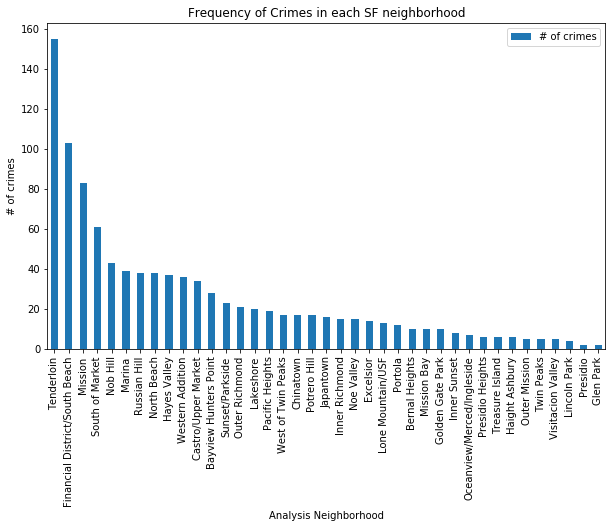

In [12]:
#plot data for SF_crimes

SF_crimes.plot(x='Analysis Neighborhood', y='# of crimes', kind='bar', figsize=(10, 6))

plt.xlabel('Analysis Neighborhood')
plt.ylabel('# of crimes')
plt.title('Frequency of Crimes in each SF neighborhood') 

plt.show()

2.3 Zillow Listings for 1 Bed 1 Bath Apartments 

In [13]:
#download dataset and read into pd dataframe
df_zillow = pd.read_excel('zillow-sf-prices.xls',
                          skiprows=2)

print('Data downloaded and read into dataframe')

Data downloaded and read into dataframe


In [14]:
#create dataframe with neccessary data
df_prices = df_zillow[['Region Name','Current']]

df_prices.drop(df_prices.index[0], inplace=True)

df_prices.rename(columns={'Region Name':'name',
                         'Current':'price'},inplace=True)

df_prices['name']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1          Alamo Square
2            Anza Vista
3          Aquatic Park
4       Ashbury Heights
5               Bayview
            ...        
89     University Mound
90         Upper Market
91    Visitacion Valley
92          West Portal
93     Western Addition
Name: name, Length: 93, dtype: object

In [15]:
#rename names that correspond to SF Find Neighborhoods
df_prices['name'].replace({'Aquatic Park':'Aquatic Park / Ft. Mason',
                          'Downtown':'Downtown / Union Square',
                          'Fisherman\'s Wharf':'Fishermans Wharf',
                          'Haight':'Haight Ashbury',
                          'Ingleside Heights':'Ingleside Terraces',
                          'Laurel Heights':'Laurel Heights / Jordan Park',
                          'North Waterfront':'Northern Waterfront'}, inplace=True)

df_prices['name']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


1                 Alamo Square
2                   Anza Vista
3     Aquatic Park / Ft. Mason
4              Ashbury Heights
5                      Bayview
                ...           
89            University Mound
90                Upper Market
91           Visitacion Valley
92                 West Portal
93            Western Addition
Name: name, Length: 93, dtype: object

In [16]:
#check if neighborhoods are included / corrently named between both datasets

x = set(df_neighborhood['name'])
y = set(df_prices['name'])

z = x.difference(y)

print("Difference of list: " + str(z))

Difference of list: {'Midtown Terrace', 'McLaren Park', 'Merced Heights', 'Golden Gate Park', 'Little Hollywood', 'Lakeshore', 'Balboa Terrace', 'Apparel City', 'Westwood Highlands', 'Produce Market', 'Stonestown', 'Mt. Davidson Manor', 'Presidio National Park', 'St. Francis Wood', 'Sunnydale', 'Forest Knolls', 'Sherwood Forest', 'Westwood Park', 'Laguna Honda', 'Monterey Heights', 'Lincoln Park / Ft. Miley', 'Yerba Buena Island', 'Merced Manor', 'Presidio Terrace', 'Treasure Island'}


In [17]:
#merge neighborhood df and prices 
df_merge = pd.merge(df_neighborhood, df_prices, on = 'name')

df_merge.sort_values(by='price', inplace=True)
df_merge.reset_index(inplace=True)
df_merge.drop('index', axis=1, inplace=True)

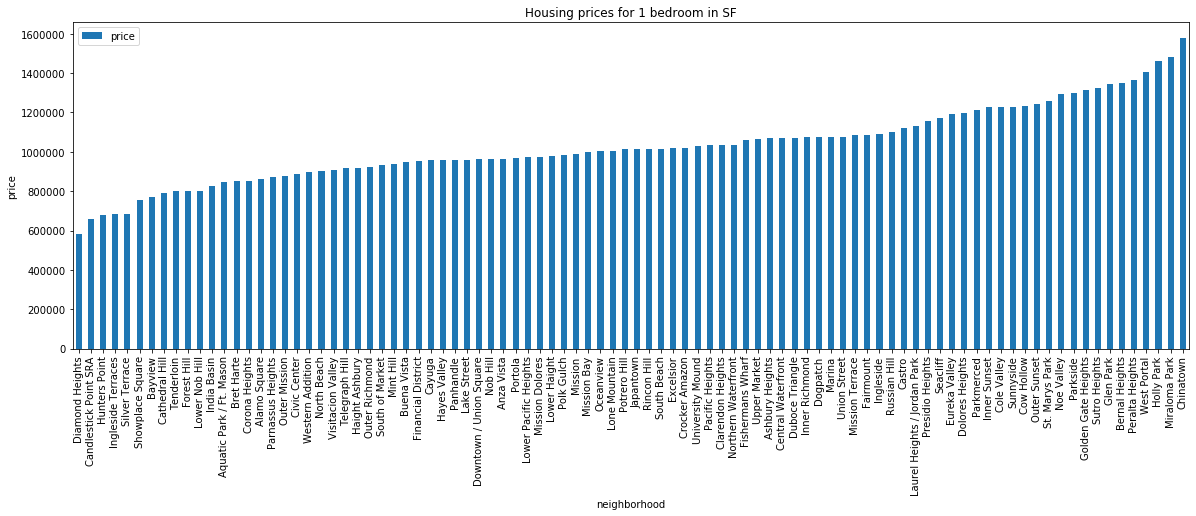

In [18]:
#plot data for housing prices in each neighborhood

df_merge.plot(x='name',y='price',kind='bar', figsize=(20,6))

plt.xlabel('neighborhood')
plt.ylabel('price')
plt.title('Housing prices for 1 bedroom in SF') 

plt.show()

In [19]:
#create choropleth map to show housing prices

sf_geo = r'SF Find Neighborhoods.geojson' #determine neighborhood boundaries

#create map and display
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='cartodbpositron')

choropleth = folium.Choropleth(
    geo_data=sf_geo,
    data=df_merge,
    columns=['name','price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='SF 1bed1bath Prices'
).add_to(sanfran_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'],labels=False)
).add_to(sanfran_map)


sanfran_map

In [20]:
#add other data onto the map

sf_geo = r'SF Find Neighborhoods.geojson'

#create map and display
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='cartodbpositron')

choropleth = folium.Choropleth(
    geo_data=sf_geo,
    data=df_merge,
    columns=['name','price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.3,
    line_opacity=0.2,
    legend_name='SF 1bed1bath Prices'
).add_to(sanfran_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'],labels=False)
).add_to(sanfran_map)

incidents = plugins.MarkerCluster().add_to(sanfran_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_incidents.Latitude, df_incidents.Longitude, df_incidents.Category):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

sanfran_map

2.4 FourSquare API

In [21]:
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors 
from sklearn.cluster import KMeans

print('libraries imported')

libraries imported


In [22]:
#define foursquare credentials
CLIENT_ID = 'AGKFTNIHJROM5RPBJPTXDJXDENC4FTW0PS53I4DQN2RA3LZW'
CLIENT_SECRET = 'AQKCUQ0DJ4HLQX2MM1TDGHFD2QK4OQVMFVZLJTASCD05JJSP'
VERSION = '20180605'

#define radius and limit
radius = 700
LIMIT = 100

In [23]:
#find nearby venues in each neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
sf_venues = getNearbyVenues(names=df_merge['name'],
                                 latitudes=df_merge['latitude'],
                                 longitudes=df_merge['longitude'])

Diamond Heights
Candlestick Point SRA
Hunters Point
Ingleside Terraces
Silver Terrace
Showplace Square
Bayview
Cathedral Hill
Tenderloin
Forest Hill
Lower Nob Hill
India Basin
Aquatic Park / Ft. Mason
Bret Harte
Corona Heights
Alamo Square
Parnassus Heights
Outer Mission
Civic Center
Western Addition
North Beach
Visitacion Valley
Telegraph Hill
Haight Ashbury
Outer Richmond
South of Market
Mint Hill
Buena Vista
Financial District
Cayuga
Hayes Valley
Panhandle
Lake Street
Downtown / Union Square
Nob Hill
Anza Vista
Portola
Lower Pacific Heights
Mission Dolores
Lower Haight
Polk Gulch
Mission
Mission Bay
Oceanview
Lone Mountain
Potrero Hill
Japantown
Rincon Hill
South Beach
Excelsior
Crocker Amazon
University Mound
Pacific Heights
Clarendon Heights
Northern Waterfront
Fishermans Wharf
Upper Market
Ashbury Heights
Central Waterfront
Duboce Triangle
Inner Richmond
Dogpatch
Marina
Union Street
Mission Terrace
Fairmount
Ingleside
Russian Hill
Castro
Laurel Heights / Jordan Park
Presidio Heig

In [25]:
sf_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Diamond Heights              37.743098             -122.440356   
1     Diamond Heights              37.743098             -122.440356   
2     Diamond Heights              37.743098             -122.440356   
3     Diamond Heights              37.743098             -122.440356   
4     Diamond Heights              37.743098             -122.440356   
...               ...                    ...                     ...   
5916        Chinatown              37.794466             -122.406601   
5917        Chinatown              37.794466             -122.406601   
5918        Chinatown              37.794466             -122.406601   
5919        Chinatown              37.794466             -122.406601   
5920        Chinatown              37.794466             -122.406601   

                                  Venue  Venue Latitude  Venue Longitude  \
0     Glen Canyon South Rim Cliff Trail       37.742359      -122.441423   
1               Harbor Villa Restaurant       37.743755      -122.439404   
2               Upper Douglass Dog Park       37.746493      -122.438764   
3                           Great Clips       37.743857      -122.439989   
4                      Glen Canyon Park       37.737362      -122.440805   
...                                 ...             ...              ...   
5916                   Pure Organic Spa       37.789286      -122.409191   
5917                    Serenity MedSpa       37.789102      -122.404292   
5918               Glow Yoga & Wellness       37.800125      -122.409114   
5919                      La Fromagerie       37.790580      -122.402360   
5920                Baonecci Ristorante       37.799697      -122.407783   

          Venue Category  
0                  Trail  
1     Dim Sum Restaurant  
2                Dog Run  
3     Salon / Barbershop  
4                   Park  
...                  ...  
5916                 Spa  
5917                 Spa  
5918         Yoga Studio  
5919   French Restaurant  
5920  Italian Restaurant  

[5921 rows x 7 columns]

In [26]:
#check values returned for neighborhood 
venues = sf_venues.groupby('Neighborhood').count()

venues.rename(columns={'Venue':'# of venues'}, inplace=True)

venues.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], axis=1, inplace=True)

venues.sort_values(by='# of venues', ascending = False, inplace=True)
venues.reset_index(inplace=True)

venues

Neighborhood  # of venues
0       Alamo Square          100
1         Noe Valley          100
2   Fishermans Wharf          100
3       Hayes Valley          100
4          Japantown          100
..               ...          ...
87       Forest Hill           10
88       India Basin            9
89     Hunters Point            9
90         Oceanview            9
91        Bret Harte            9

[92 rows x 2 columns]

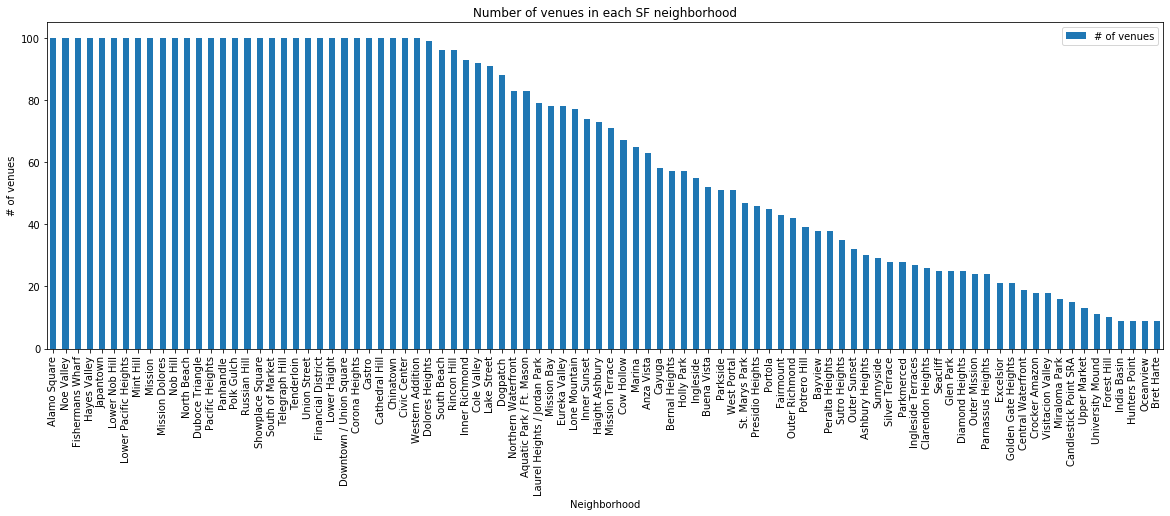

In [27]:
#plot data for number of venues in each neighborhood

venues.plot(x='Neighborhood',y='# of venues',kind='bar', figsize=(20, 6))

plt.xlabel('Neighborhood')
plt.ylabel('# of venues')
plt.title('Number of venues in each SF neighborhood') 

plt.show()

In [28]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 367 uniques categories.


In [29]:
#one hot encoding 
sf_onehot = pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues['Neighborhood']

#create new column list with neighborhood in front
fixed_columns = ['Neighborhood']

for col in list(sf_onehot.columns):
    if col != 'Neighborhood': #adding dummy data after neighborhood
        fixed_columns.append(col)

sf_onehot = sf_onehot[fixed_columns]

sf_onehot.head()

Neighborhood  ATM  Acai House  Accessories Store  Adult Boutique  \
0  Diamond Heights    0           0                  0               0   
1  Diamond Heights    0           0                  0               0   
2  Diamond Heights    0           0                  0               0   
3  Diamond Heights    0           0                  0               0   
4  Diamond Heights    0           0                  0               0   

   Afghan Restaurant  African Restaurant  Alternative Healer  \
0                  0                   0                   0   
1                  0                   0                   0   
2                  0                   0                   0   
3                  0                   0                   0   
4                  0                   0                   0   

   American Restaurant  Amphitheater  ...  Vineyard  Waterfront  Whisky Bar  \
0                    0             0  ...         0           0           0   
1                    0             0  ...         0           0           0   
2                    0             0  ...         0           0           0   
3                    0             0  ...         0           0           0   
4                    0             0  ...         0           0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0         0          0       0            0              0            0   
1         0          0       0            0              0            0   
2         0          0       0            0              0            0   
3         0          0       0            0              0            0   
4         0          0       0            0              0            0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 367 columns]

In [30]:
#group neighborhood by frequency of catagory
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()

sf_grouped

Neighborhood  ATM  Acai House  Accessories Store  \
0               Alamo Square  0.0         0.0                0.0   
1                 Anza Vista  0.0         0.0                0.0   
2   Aquatic Park / Ft. Mason  0.0         0.0                0.0   
3            Ashbury Heights  0.0         0.0                0.0   
4                    Bayview  0.0         0.0                0.0   
..                       ...  ...         ...                ...   
87          University Mound  0.0         0.0                0.0   
88              Upper Market  0.0         0.0                0.0   
89         Visitacion Valley  0.0         0.0                0.0   
90               West Portal  0.0         0.0                0.0   
91          Western Addition  0.0         0.0                0.0   

    Adult Boutique  Afghan Restaurant  African Restaurant  Alternative Healer  \
0              0.0                0.0            0.000000                 0.0   
1              0.0                0.0            0.000000                 0.0   
2              0.0                0.0            0.000000                 0.0   
3              0.0                0.0            0.000000                 0.0   
4              0.0                0.0            0.026316                 0.0   
..             ...                ...                 ...                 ...   
87             0.0                0.0            0.000000                 0.0   
88             0.0                0.0            0.000000                 0.0   
89             0.0                0.0            0.000000                 0.0   
90             0.0                0.0            0.000000                 0.0   
91             0.0                0.0            0.000000                 0.0   

    American Restaurant  Amphitheater  ...  Vineyard  Waterfront  Whisky Bar  \
0              0.000000           0.0  ...       0.0         0.0         0.0   
1              0.000000           0.0  ...       0.0         0.0         0.0   
2              0.000000           0.0  ...       0.0         0.0         0.0   
3              0.000000           0.0  ...       0.0         0.0         0.0   
4              0.000000           0.0  ...       0.0         0.0         0.0   
..                  ...           ...  ...       ...         ...         ...   
87             0.000000           0.0  ...       0.0         0.0         0.0   
88             0.076923           0.0  ...       0.0         0.0         0.0   
89             0.000000           0.0  ...       0.0         0.0         0.0   
90             0.000000           0.0  ...       0.0         0.0         0.0   
91             0.010000           0.0  ...       0.0         0.0         0.0   

    Wine Bar  Wine Shop    Winery  Wings Joint  Women's Store  Yoga Studio  \
0   0.020000   0.000000  0.000000          0.0            0.0     0.020000   
1   0.015873   0.000000  0.000000          0.0            0.0     0.000000   
2   0.000000   0.000000  0.012048          0.0            0.0     0.000000   
3   0.066667   0.000000  0.000000          0.0            0.0     0.000000   
4   0.000000   0.000000  0.000000          0.0            0.0     0.000000   
..       ...        ...       ...          ...            ...          ...   
87  0.000000   0.090909  0.000000          0.0            0.0     0.000000   
88  0.000000   0.000000  0.000000          0.0            0.0     0.000000   
89  0.000000   0.000000  0.000000          0.0            0.0     0.000000   
90  0.039216   0.019608  0.000000          0.0            0.0     0.019608   
91  0.010000   0.000000  0.000000          0.0            0.0     0.020000   

    Zoo Exhibit  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
..          ...  
87          0.0  
88          0.0  
89          0.0  
90          0.0  
91          0.0  

[92 rows x 367 columns]

In [31]:
#write function to sort venues in desc order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
#create df to display top 10 venues for each 
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.rename(columns={'Neighborhood':'name'}, inplace=True)

neighborhoods_venues_sorted.head()

name            1st Most Common Venue  \
0              Alamo Square                      Coffee Shop   
1                Anza Vista                      Coffee Shop   
2  Aquatic Park / Ft. Mason                      Art Gallery   
3           Ashbury Heights                             Park   
4                   Bayview  Southern / Soul Food Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   Bar                  Café      Sushi Restaurant   
1                  Café        Cosmetics Shop    Mexican Restaurant   
2            Food Truck        Chocolate Shop               Theater   
3                 Trail        Breakfast Spot           Bus Station   
4                Bakery    Light Rail Station                  Café   

  5th Most Common Venue 6th Most Common Venue          7th Most Common Venue  \
0           Record Shop              Dive Bar                  Burrito Place   
1      Sushi Restaurant        Sandwich Place                       Bus Line   
2                  Park         Historic Site  Vegetarian / Vegan Restaurant   
3              Wine Bar     Convenience Store                 Hardware Store   
4    Mexican Restaurant                   Gym                        Theater   

  8th Most Common Venue      9th Most Common Venue  \
0              Boutique   Mediterranean Restaurant   
1         Grocery Store       Gym / Fitness Center   
2                 Hotel              National Park   
3    Mexican Restaurant  Middle Eastern Restaurant   
4                  Park     Thrift / Vintage Store   

            10th Most Common Venue  
0             Ethiopian Restaurant  
1  Southern / Soul Food Restaurant  
2               Seafood Restaurant  
3                      Cheese Shop  
4                       Taco Place

In [33]:
#download libraries

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

print('libraries imported')


libraries imported


In [34]:
#clustering neighborhoods
kclusters=5

sf_grouped_clustering = sf_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 2, 0, 0, 1, 0, 4, 0], dtype=int32)

In [35]:
#create dataframe that includes cluster and top10 venue
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [36]:
sf_merged = df_merge

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

sf_merged

name   latitude   longitude    price  Cluster Labels  \
0         Diamond Heights  37.743098 -122.440356   583600               2   
1   Candlestick Point SRA  37.714110 -122.388192   656800               4   
2           Hunters Point  37.725608 -122.371341   677700               0   
3      Ingleside Terraces  37.726545 -122.467861   682400               0   
4          Silver Terrace  37.734842 -122.400505   683700               0   
..                    ...        ...         ...      ...             ...   
87        Peralta Heights  37.745488 -122.407347  1364200               0   
88            West Portal  37.740790 -122.467424  1406400               0   
89             Holly Park  37.736433 -122.421655  1461100               0   
90          Miraloma Park  37.738863 -122.448326  1481800               2   
91              Chinatown  37.794466 -122.406601  1578900               0   

        1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0                        Park           Bus Station                  Trail   
1                    Mountain      Football Stadium                   Park   
2             Harbor / Marina          Food Service             Restaurant   
3                  Playground            Food Truck            Yoga Studio   
4          Chinese Restaurant         Grocery Store              Nightclub   
..                        ...                   ...                    ...   
87                    Brewery         Deli / Bodega      Convenience Store   
88                Coffee Shop     Indian Restaurant     Mexican Restaurant   
89  Latin American Restaurant    Mexican Restaurant            Coffee Shop   
90                       Park                 Trail  Outdoors & Recreation   
91                Coffee Shop                 Hotel            Men's Store   

      4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                Playground        Scenic Lookout              Pharmacy   
1       American Restaurant     Food & Drink Shop            Campground   
2             Grocery Store          Home Service        Scenic Lookout   
3        Chinese Restaurant                  Park           Coffee Shop   
4                     Diner           Gas Station           Pet Service   
..                      ...                   ...                   ...   
87     Fast Food Restaurant                  Park         Grocery Store   
88             Burger Joint    Chinese Restaurant                   Pub   
89                     Park          Gourmet Shop                Bakery   
90                 Bus Line         Grocery Store              Mountain   
91  New American Restaurant    Italian Restaurant       Bubble Tea Shop   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0     Salon / Barbershop           Coffee Shop         Shopping Mall   
1           Soccer Field                  Café      Business Service   
2                    Spa                  Park           Art Gallery   
3                 Bakery  Gym / Fitness Center                   Gym   
4           Soccer Field              Pharmacy        Baseball Field   
..                   ...                   ...                   ...   
87    Mexican Restaurant          Liquor Store             Nightclub   
88           Pizza Place                  Park         Grocery Store   
89          Liquor Store                  Café         Grocery Store   
90    Athletics & Sports                  Tree            Playground   
91                   Gym                Bakery                  Café   

     10th Most Common Venue  
0                   Dog Run  
1   Health & Beauty Service  
2               Zoo Exhibit  
3            Shipping Store  
4                Donut Shop  
..                      ...  
87                     Pool  
88       Italian Restaurant  
89       Italian Restaurant  
90      Monument / Landmark  
91               Restaurant  

[92 rows x 15 columns]

In [37]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['latitude'], sf_merged['longitude'], sf_merged['name'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sanfran_map)
    
folium.LayerControl().add_to(sanfran_map)
       
sanfran_map

In [38]:
#examining clusters
#cluster 1
sf_merged.loc[sf_merged['Cluster Labels'] == 0, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]].reset_index(drop=True)

name            1st Most Common Venue 2nd Most Common Venue  \
0        Hunters Point                  Harbor / Marina          Food Service   
1   Ingleside Terraces                       Playground            Food Truck   
2       Silver Terrace               Chinese Restaurant         Grocery Store   
3     Showplace Square           Furniture / Home Store           Art Gallery   
4              Bayview  Southern / Soul Food Restaurant                Bakery   
..                 ...                              ...                   ...   
72      Bernal Heights                           Bakery           Coffee Shop   
73     Peralta Heights                          Brewery         Deli / Bodega   
74         West Portal                      Coffee Shop     Indian Restaurant   
75          Holly Park        Latin American Restaurant    Mexican Restaurant   
76           Chinatown                      Coffee Shop                 Hotel   

   3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
0             Restaurant            Grocery Store          Home Service   
1            Yoga Studio       Chinese Restaurant                  Park   
2              Nightclub                    Diner           Gas Station   
3            Coffee Shop                      Gym               Gay Bar   
4     Light Rail Station                     Café    Mexican Restaurant   
..                   ...                      ...                   ...   
72    Italian Restaurant                     Park    Mexican Restaurant   
73     Convenience Store     Fast Food Restaurant                  Park   
74    Mexican Restaurant             Burger Joint    Chinese Restaurant   
75           Coffee Shop                     Park          Gourmet Shop   
76           Men's Store  New American Restaurant    Italian Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Scenic Lookout                   Spa                  Park   
1              Coffee Shop                Bakery  Gym / Fitness Center   
2              Pet Service          Soccer Field              Pharmacy   
3               Food Truck  Gym / Fitness Center                   Bar   
4                      Gym               Theater                  Park   
..                     ...                   ...                   ...   
72  Furniture / Home Store        Farmers Market          Gourmet Shop   
73           Grocery Store    Mexican Restaurant          Liquor Store   
74                     Pub           Pizza Place                  Park   
75                  Bakery          Liquor Store                  Café   
76         Bubble Tea Shop                   Gym                Bakery   

     9th Most Common Venue 10th Most Common Venue  
0              Art Gallery            Zoo Exhibit  
1                      Gym         Shipping Store  
2           Baseball Field             Donut Shop  
3          Thai Restaurant            Music Venue  
4   Thrift / Vintage Store             Taco Place  
..                     ...                    ...  
72              Playground            Pizza Place  
73               Nightclub                   Pool  
74           Grocery Store     Italian Restaurant  
75           Grocery Store     Italian Restaurant  
76                    Café             Restaurant  

[77 rows x 11 columns]

In [39]:
#cluster 2
sf_merged.loc[sf_merged['Cluster Labels'] == 1, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]].reset_index(drop=True)

name 1st Most Common Venue 2nd Most Common Venue  \
0         Bret Harte               Brewery         Grocery Store   
1  Visitacion Valley           Coffee Shop         Grocery Store   
2          Oceanview    Light Rail Station           Coffee Shop   
3          Sunnyside                  Park    Light Rail Station   

  3rd Most Common Venue       4th Most Common Venue 5th Most Common Venue  \
0        Breakfast Spot                Burger Joint            Food Truck   
1                  Park  Construction & Landscaping  Marijuana Dispensary   
2           Supermarket                        Park         Grocery Store   
3            Food Truck               Deli / Bodega          Tennis Court   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Latin American Restaurant                  Park    Light Rail Station   
1                 Donut Shop                  Café    Light Rail Station   
2                       Food    Spanish Restaurant       Thai Restaurant   
3                        Spa        Baseball Field                   Bar   

  9th Most Common Venue 10th Most Common Venue  
0    Mexican Restaurant   Fast Food Restaurant  
1                 Trail         Sandwich Place  
2            Playground                   Farm  
3        Sandwich Place                  Trail

In [40]:
#cluster 3
sf_merged.loc[sf_merged['Cluster Labels'] == 2, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]].reset_index(drop=True)

name 1st Most Common Venue 2nd Most Common Venue  \
0      Diamond Heights                  Park           Bus Station   
1    Parnassus Heights                 Trail                  Park   
2    Clarendon Heights                 Trail        Scenic Lookout   
3         Upper Market                 Trail        Scenic Lookout   
4      Ashbury Heights                  Park                 Trail   
5  Golden Gate Heights                  Park                 Trail   
6            Glen Park                  Park                 Trail   
7        Miraloma Park                  Park                 Trail   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Trail            Playground        Scenic Lookout   
1                 Garden           Coffee Shop                   ATM   
2                   Park           Bus Station            Playground   
3                   Park                  Hill           Coffee Shop   
4         Breakfast Spot           Bus Station              Wine Bar   
5             Playground           Event Space          Dance Studio   
6             Playground        Baseball Field           Coffee Shop   
7  Outdoors & Recreation              Bus Line         Grocery Store   

  6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0              Pharmacy     Salon / Barbershop           Coffee Shop   
1              Mountain    Monument / Landmark             Cafeteria   
2                  Hill            Tailor Shop   Monument / Landmark   
3             Reservoir    American Restaurant       Thai Restaurant   
4     Convenience Store         Hardware Store    Mexican Restaurant   
5                Garden         Scenic Lookout           Fish Market   
6              Pharmacy  Outdoors & Recreation              Mountain   
7              Mountain     Athletics & Sports                  Tree   

       9th Most Common Venue 10th Most Common Venue  
0              Shopping Mall                Dog Run  
1                  Gift Shop            College Gym  
2              Grocery Store               Bus Stop  
3                Fabric Shop     Falafel Restaurant  
4  Middle Eastern Restaurant            Cheese Shop  
5                       Farm         Farmers Market  
6                   Bus Line     Dim Sum Restaurant  
7                 Playground    Monument / Landmark

In [41]:
#cluster 4
sf_merged.loc[sf_merged['Cluster Labels'] == 3, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]].reset_index(drop=True)

name 1st Most Common Venue 2nd Most Common Venue  \
0  Forest Hill                  Park     French Restaurant   
1  India Basin                  Park                   Spa   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Garden        Scenic Lookout            Playground   
1               Brewery         Garden Center            Waterfront   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Hotpot Restaurant   Japanese Restaurant            Food Stand   
1          Home Service           Coffee Shop           Fish Market   

  9th Most Common Venue 10th Most Common Venue  
0          Food Service     Falafel Restaurant  
1                  Farm         Farmers Market

In [42]:
#cluster 5
sf_merged.loc[sf_merged['Cluster Labels'] == 4, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]].reset_index(drop=True)

name 1st Most Common Venue 2nd Most Common Venue  \
0  Candlestick Point SRA              Mountain      Football Stadium   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Park   American Restaurant     Food & Drink Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Campground          Soccer Field                  Café   

  9th Most Common Venue   10th Most Common Venue  
0      Business Service  Health & Beauty Service